# 데이터 탐색

In [1]:
import os
import cv2

BASE_DIR = r"D:\01.project\codeitmission8\mission8\data\football"


# 폴더 내 모든 파일 목록 가져오기
image_folder = os.path.join(BASE_DIR, "images")
file_list = os.listdir(image_folder)

# 원본 이미지(.jpg)와 fuse 이미지 매칭
original_files = sorted([f for f in file_list if f.endswith(".jpg")])
fuse_files = sorted([f for f in file_list if "fuse" in f])

# 이미지 로드 및 확인
image_pairs = []
for orig_file in original_files:
    # 동일한 프레임의 fuse 파일 찾기
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        # 원본과 마스크 로드
        img_path = os.path.join(image_folder, orig_file)
        mask_path = os.path.join(image_folder, fuse_file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        if img is not None and mask is not None:
            image_pairs.append((img, mask))

# 최종적으로 로드된 이미지 쌍 개수 출력
print(f"{len(image_pairs)} pairs")

100 pairs


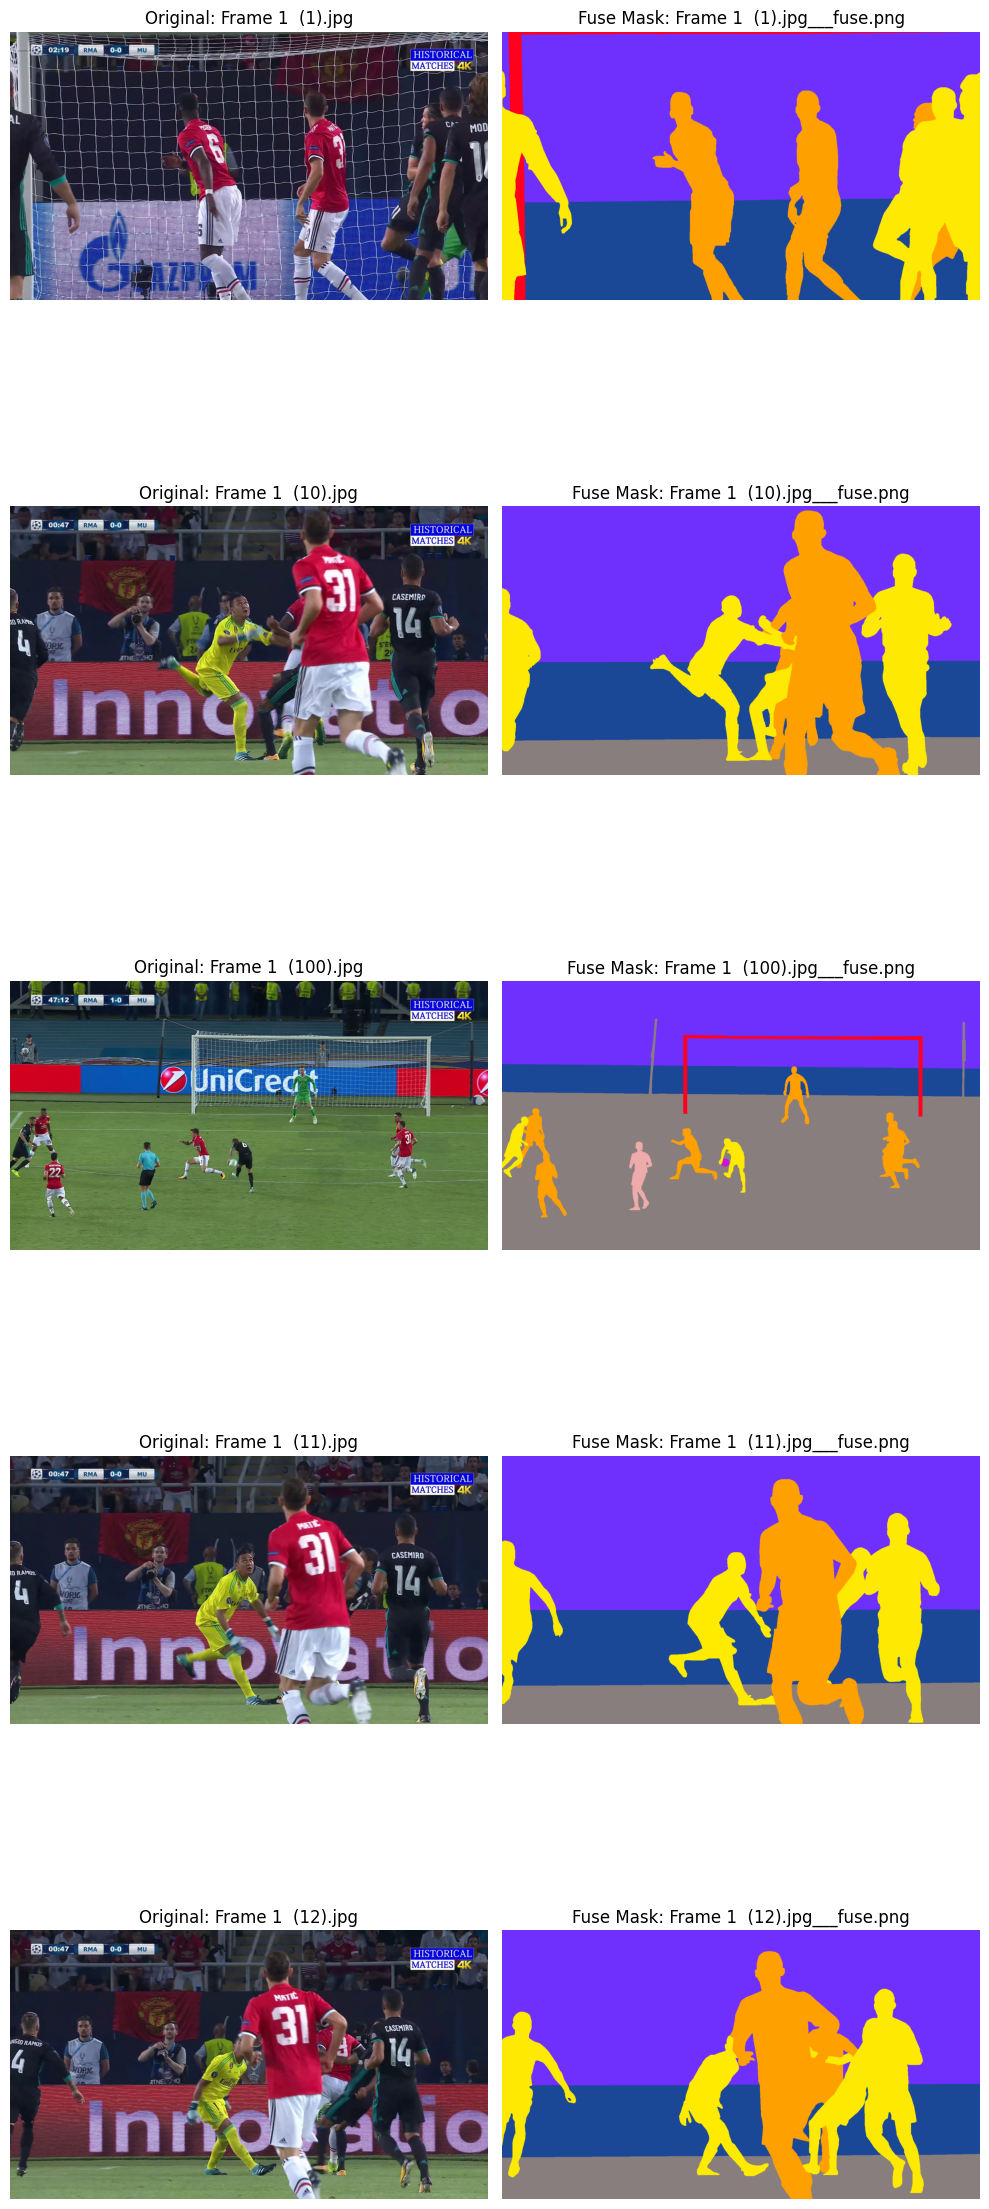

In [2]:
import matplotlib.pyplot as plt

sample_image_pairs = []
num_samples = 5

for orig_file in original_files[:num_samples]:
    base_name = orig_file.replace(".jpg", "")
    fuse_file = next((f for f in fuse_files if base_name in f), None)

    if fuse_file:
        sample_image_pairs.append((orig_file, fuse_file))

# 이미지 5쌍 시각화
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

for i, (orig_file, fuse_file) in enumerate(sample_image_pairs):
    # 이미지 로드
    orig_img = cv2.imread(os.path.join(image_folder, orig_file))
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)  # OpenCV BGR → RGB 변환

    fuse_img = cv2.imread(os.path.join(image_folder, fuse_file))
    fuse_img = cv2.cvtColor(fuse_img, cv2.COLOR_BGR2RGB)  # 마스크도 RGB 변환

    # 시각화
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {orig_file}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(fuse_img)
    axes[i, 1].set_title(f"Fuse Mask: {fuse_file}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# 데이터 불러오기

In [3]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 데이터셋 전체의 고유한 색상 수집
def get_unique_colors(image_folder, mask_files, max_classes=11):
    color_set = set()

    for mask_file in mask_files:
        mask_path = os.path.join(image_folder, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

        for color in unique_colors:
            color_set.add(tuple(color))  # 고유한 색상 저장

            # 클래스 개수가 max_classes개가 되면 중단
            if len(color_set) >= max_classes:
                return list(color_set)  # 최대 max_classes개까지만 반환

    return list(color_set)  # 모든 마스크를 순회 후 반환

# 모든 마스크에서 등장하는 색상 수집
unique_colors = get_unique_colors(image_folder, fuse_files)
color_to_label = {color: idx for idx, color in enumerate(unique_colors)}
print("데이터 로딩.")

데이터 로딩.


In [4]:
# 데이터셋 클래스 정의 (RGB 마스크 변환 포함)
class FootballDataset(Dataset):
    def __init__(self, image_files, mask_files, image_folder, color_to_label):
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_folder = image_folder
        self.color_to_label = color_to_label  # 고정된 클래스 매핑

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.image_folder, self.mask_files[idx])

        # 원본 이미지 로드
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256)) / 255.0  # 정규화

        # 마스크 로드 (RGB 모드)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        # 고정된 color_to_label을 사용하여 클래스 변환
        mask_class = np.zeros(mask.shape[:2], dtype=np.uint8)
        for color, label in self.color_to_label.items():
            mask_class[(mask == color).all(axis=-1)] = label  # 고정된 ID 사용

        # PyTorch 텐서 변환
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        mask = torch.tensor(mask_class, dtype=torch.long)  # (H, W)

        return img, mask
print("Define FootballDataset class")

Define FootballDataset class


In [5]:
# 데이터 로드
dataset = FootballDataset(original_files, fuse_files, image_folder, color_to_label)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

print(f"Train Data: {len(train_dataset)}, Test Data: {len(test_dataset)}")

Train Data: 80, Test Data: 20


# 모델 학습 및 평가

In [6]:
# U-Net 모델 정의 (BatchNorm 추가)
class UNet(nn.Module):
    def __init__(self, num_classes=11):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # BatchNorm 추가
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),  # BatchNorm 추가
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(3, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.upconv3(b)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)  # logits 출력
print("Define UNet model")

Define UNet model


In [9]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(num_classes=11).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        masks = torch.clamp(masks, min=0, max=10)  # 0~10 범위 유지

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/50], Loss: 1.3937
Epoch [2/50], Loss: 0.8146


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    test_iter = iter(test_loader)
    plt.figure(figsize=(15, 80))

    plot_index = 1
    for images, masks in test_iter:
        images = images.to(device)
        outputs = model(images)
        pred_masks = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu().numpy()

        for b in range(images.size(0)):
            plt.subplot(20, 3, plot_index)
            plt.imshow(images[b].cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.axis("off")
            plot_index += 1

            plt.subplot(20, 3, plot_index)
            plt.imshow(masks[b].cpu().numpy(), cmap="jet")
            plt.title("Ground Truth Mask")
            plt.axis("off")
            plot_index += 1

            plt.subplot(20, 3, plot_index)
            plt.imshow(pred_masks[b], cmap="jet")
            plt.title("Predicted Mask")
            plt.axis("off")
            plot_index += 1

            if plot_index > 20 * 3:  # 20개 이미지까지 시각화
                break
        if plot_index > 20 * 3:
            break

    plt.tight_layout()
    plt.show()